<a href="https://colab.research.google.com/github/NathanyApSalles/analysis_foodtech/blob/main/Case_Tecnico_DataAnalyst_Ifood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de teste a/b - envio de cupons
---


**Importação das bases**

In [1]:
import requests
import tarfile
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import shapiro, anderson, boxcox, mannwhitneyu
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import col, broadcast, when, count, isnan, count_distinct, sum, avg, row_number, lag, date_diff, round, max, to_date, lit, date_format
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()

**Leitura e carregamento de bases**

In [2]:
def read_file(url: str, local_path: str, type_file: str) -> DataFrame:
  """Função para ler arquivo e retornar um Dataframe."""
  if not os.path.exists(local_path):
    response = requests.get(url)
    with open(local_path, "wb") as f:
        f.write(response.content)
  if type_file == "json":
    return spark.read.json(local_path, multiLine=False)
  elif type_file == "csv":
    return spark.read.option("header", "true").csv(local_path)
  elif type_file == "tar":

    arquivos_extraidos = "/tmp/ab_test_ref"

    os.makedirs(arquivos_extraidos, exist_ok=True)

    with tarfile.open(local_path, "r:gz") as tar:
        tar.extractall(path=arquivos_extraidos)

    filename = ""
    for root, dirs, files in os.walk(arquivos_extraidos):
        for filename in files:
            print(filename) # print para visualizar todos os arquivos exraídos
    if ".csv" in filename: # se houver algum arquivo csv, junte todos os arquivos deste tipo no dataframe
      return spark.read.option("header", "true").csv(arquivos_extraidos + "/*.csv")
    else: # se houver algum arquivo json, junte todos os arquivos deste tipo no dataframe
      return spark.read.json(arquivos_extraidos + "/*.json")
      #pode acontecer de ter arquivos de diferentes tipos misturados, mas para este estudo vamos assumir que todos são do mesmo tipo


In [3]:
url_pedidos = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz"
url_usuarios = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz"
url_merchants = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz"
url_test_ab = "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"

local_path_pedidos = "/tmp/order.json.gz"
local_path_usuarios = "/tmp/consumer.csv.gz"
local_path_merchants = "/tmp/restaurant.csv.gz"
local_path_teste_ab = "/tmp/ab_test_ref.tar.gz"

pedidos = read_file(url_pedidos, local_path_pedidos, "json").cache()
usuarios = read_file(url_usuarios, local_path_usuarios, "csv").cache()
merchants = read_file(url_merchants, local_path_merchants, "csv").cache()
teste_ab = read_file(url_test_ab, local_path_teste_ab, "tar").cache()

ab_test_ref.csv
._ab_test_ref.csv


**Visualização das bases**

In [4]:
pedidos.show(5)

+-----------+--------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+--------------------+--------------------+---------------+--------------------+------------------+---------------+
|        cpf|         customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|    order_created_at|            order_id|order_scheduled|order_scheduled_date|order_total_amount|origin_platform|
+-----------+--------------------+-------------+---------------------+--

In [5]:
usuarios.show(5)

+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+
|e8cc60860e09c0bb1...|   pt-br|2018-04-05T14:49:...|  true|         NUNO|                 46|            816135924|
|a2834a38a9876cf74...|   pt-br|2018-01-14T21:40:...|  true|     ADRIELLY|                 59|            231330577|
|41e1051728eba1334...|   pt-br|2018-01-07T03:47:...|  true|        PAULA|                 62|            347597883|
|8e7c1dcb64edf95c9...|   pt-br|2018-01-10T22:17:...|  true|       HELTON|                 13|            719366842|
|7823d4cf4150c5dae...|   pt-br|2018-04-06T00:16:...|  true|       WENDER|                 76|            543232158|
+--------------------+--------+--------------------+------+-------------

In [6]:
merchants.show(5)

+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|                  id|          created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code| merchant_city|merchant_state|merchant_country|
+--------------------+--------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|d19ff6fca6288939b...|2017-01-23T12:52:...|  false|          3|          60.0|           0|           50|               30.0|            14025|RIBEIRAO PRETO|            SP|              BR|
|631df0985fdbbaf27...|2017-01-20T13:14:...|   true|          3|          60.0|           0|            0|               30.0|            50180|     SAO PAULO|            SP|              BR|
|135c5c4ae4c1ec1fd...|2017-01-23T12:46:...|  

In [7]:
teste_ab.show(5, truncate=False)

+----------------------------------------------------------------+---------+
|customer_id                                                     |is_target|
+----------------------------------------------------------------+---------+
|755e1fa18f25caec5edffb188b13fd844b2af8cf5adedcf77c028f36cb9382ea|target   |
|b821aa8372b8e5b82cdc283742757df8c45eecdd72adf411716e710525d4edf1|control  |
|d425d6ee4c9d4e211b71da8fc60bf6c5336b2ea9af9cc007f5297541ec40b63b|control  |
|6a7089eea0a5dc294fbccd4fa24d0d84a90c1cc12e829c8b535718bbc651ab02|target   |
|dad6b7e222bab31c0332b0ccd9fa5dbd147008facd268f5e3763fa657c23a58d|control  |
+----------------------------------------------------------------+---------+
only showing top 5 rows



**Limpeza dos dados**

In [8]:
def df_info(df: DataFrame, colunas: list) -> None:
  """Função para auxiliar a identificar tamanho da base,
   valores nulos, duplicidade em colunas específicas na base."""
  # validando o tipo das colunas
  df.printSchema()

  # validando o tamanho da base
  print(f"Qtd de linhas: {df.count()}")

  print("\nValores nulos")
  df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

  print("\nValidando valores duplicados")
  for column in colunas:
    num_duplicados = df.groupBy(column).count().where(col("count") > 1).count()
    print(f"\n{column}: {num_duplicados}")

In [9]:
df_info(usuarios, ["customer_id"])

root
 |-- customer_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- active: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_phone_area: string (nullable = true)
 |-- customer_phone_number: string (nullable = true)

Qtd de linhas: 806156

Valores nulos
+-----------+--------+----------+------+-------------+-------------------+---------------------+
|customer_id|language|created_at|active|customer_name|customer_phone_area|customer_phone_number|
+-----------+--------+----------+------+-------------+-------------------+---------------------+
|          0|       0|         0|     0|            0|                  0|                    0|
+-----------+--------+----------+------+-------------+-------------------+---------------------+


Validando valores duplicados

customer_id: 0


In [10]:
df_info(pedidos, ["order_id"])

root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: string (nullable = true)
 |-- delivery_address_longitude: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: string (nullable = true)
 |-- merchant_longitude: string (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: string (nullable = true)
 |--

In [11]:
# removendo os usuários nulos da base
# na base de pedidos temos um número pequeno de pedidos sem customer_id atribuído,
# porém como o objetivo da análise é validar os resultados do teste a/b, estes pedidos serão removidos visto que
# não participaram do teste a/b
pedidos_validos_ab = pedidos.where(col("customer_id").isNotNull())

In [12]:
# podemos ver que a base de pedidos possui uma grande volumentria de pedidos duplicados
# foi analisado uma amostra e notou-se que para os pedidos duplicados, os campos que diferem são CPF e data de criação do pedido
# pode ter acontecido algum problema no produto ao gerar o número do pedido, ou até mesmo ao gerar a base,
# diantes disto podemos seguir com algumas tratativas, como criar um novo order_id concatenando com o CPF, ou
# dentro dos duplicados manter o pedido mais atual, ou a mais antigo.
# Como os valores dos pedidos são iguais, merchants, itens também são idênticos, optou-se por manter o pedido mais antigo

pedidos_validos_ab = (pedidos_validos_ab
                      .withColumn("rank", row_number().over(Window.partitionBy("order_id").orderBy("order_created_at")))
                      .where(col("rank") == 1)
                      .drop("rank")
).cache()
df_info(pedidos_validos_ab, ["order_id"])

root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: string (nullable = true)
 |-- delivery_address_longitude: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: string (nullable = true)
 |-- merchant_longitude: string (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: string (nullable = true)
 |--

In [13]:
df_info(merchants, ["id"])

root
 |-- id: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- enabled: string (nullable = true)
 |-- price_range: string (nullable = true)
 |-- average_ticket: string (nullable = true)
 |-- takeout_time: string (nullable = true)
 |-- delivery_time: string (nullable = true)
 |-- minimum_order_value: string (nullable = true)
 |-- merchant_zip_code: string (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- merchant_country: string (nullable = true)

Qtd de linhas: 7292

Valores nulos
+---+----------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+-------------+--------------+----------------+
| id|created_at|enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code|merchant_city|merchant_state|merchant_country|
+---+----------+-------+-----------+--------------+------------+-------------+-------------------+---

In [14]:
df_info(teste_ab, ["customer_id"])

root
 |-- customer_id: string (nullable = true)
 |-- is_target: string (nullable = true)

Qtd de linhas: 806467

Valores nulos
+-----------+---------+
|customer_id|is_target|
+-----------+---------+
|          0|        0|
+-----------+---------+


Validando valores duplicados

customer_id: 0


# **Análise Exploratória**

In [15]:
# existem usuários no teste_Ab mas que não compraram? ou seja, não está na base de pedidos?
c = pedidos_validos_ab.select(col("customer_id").alias("custumer_with_order")).distinct()
teste_ab.join(c, col("customer_id") == col("custumer_with_order"), "left").where(col("custumer_with_order").isNull()).show()

+-----------+---------+-------------------+
|customer_id|is_target|custumer_with_order|
+-----------+---------+-------------------+
|       null|   target|               NULL|
+-----------+---------+-------------------+



In [16]:
#identificando os pedidos feitos por usuários target e control

pedidos_final = pedidos_validos_ab.join(broadcast(teste_ab), ['customer_id'], "left") \
.withColumn("order_created_at", col("order_created_at").cast("timestamp")) \
.withColumn("order_created_day", col("order_created_at").cast("date")).cache()

- Comparação tarquet x control

    - recência (considerando a data de comparar como 01/02/2019, visto que a base é entre dez/18 e jan/19);
    - frequência: qtd de pedidos;
    - valor total da compra; (análise RFV)
    - ticket médio;
    - tempo entre compras;
    - média de pedidos por usuário;     
    - expansão geográfica: qtd de estabelecimentos diferentes que compraram;

In [17]:
pedidos_final.groupBy(col("is_target")).agg(
                                      count_distinct(col("order_id")).alias("distinct_orders"),
                                      count_distinct(col("customer_id")).alias("distinct_customers"),
                                      count_distinct(col("merchant_id")).alias("distinct_merchants"),
                                      round(sum(col("order_total_amount")),2).alias("order_total_amount"),
                                      round((sum(col("order_total_amount"))/count_distinct(col("order_id"))),2).alias("ticket_medio"),

                                      ).show()

+---------+---------------+------------------+------------------+------------------+------------+
|is_target|distinct_orders|distinct_customers|distinct_merchants|order_total_amount|ticket_medio|
+---------+---------------+------------------+------------------+------------------+------------+
|  control|        1010738|            360542|              7196|     4.843220349E7|       47.92|
|   target|        1416677|            445924|              7227|     6.772998645E7|       47.81|
+---------+---------------+------------------+------------------+------------------+------------+



In [18]:
df_temp = pedidos_final.groupBy("order_created_day", "is_target").agg(
    count_distinct("order_id").alias("distinct_orders"),
    count_distinct("customer_id").alias("distinct_customers"),
    count_distinct("merchant_id").alias("distinct_merchants"),
    round(sum("order_total_amount"), 2).alias("order_total_amount"),
    round(
        sum("order_total_amount") / count_distinct("order_id"), 2
    ).alias("ticket_medio")
)

df = df_temp.toPandas()

<ipython-input-19-7594661daed9>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='order_created_day', y='distinct_orders', hue='is_target', marker='o', ci=None)


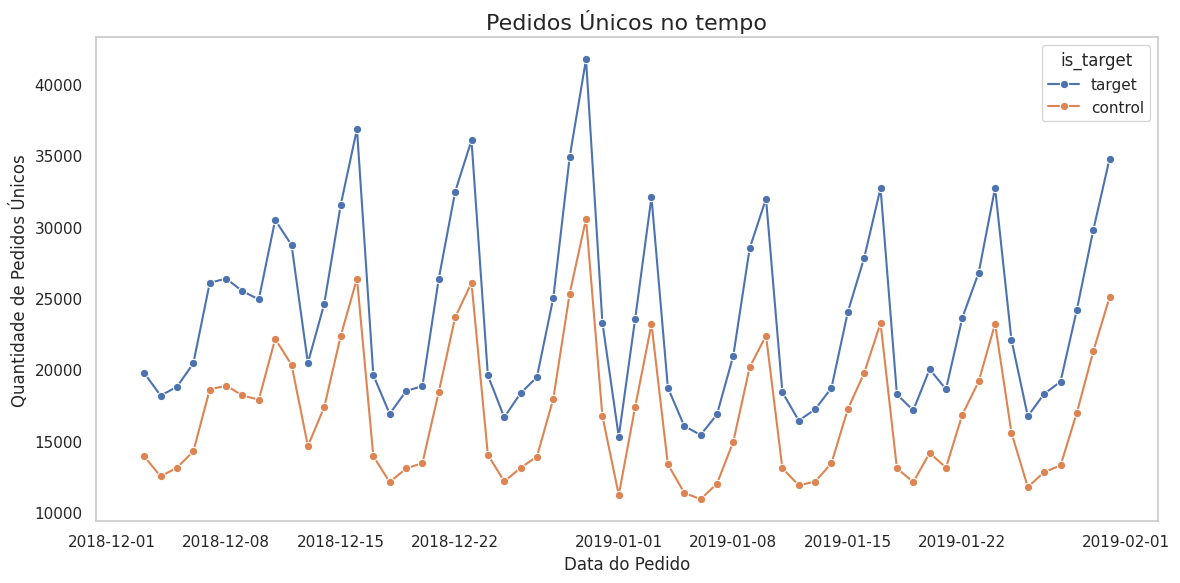

In [19]:
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")
sns.lineplot(data=df, x='order_created_day', y='distinct_orders', hue='is_target', marker='o', ci=None)

plt.title('Pedidos Únicos no tempo', fontsize=16)
plt.xlabel('Data do Pedido', fontsize=12)
plt.ylabel('Quantidade de Pedidos Únicos', fontsize=12)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(False)

plt.show()

<ipython-input-20-3006b32d506a>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='order_created_day', y='order_total_amount', hue='is_target', marker='o', ci=None)


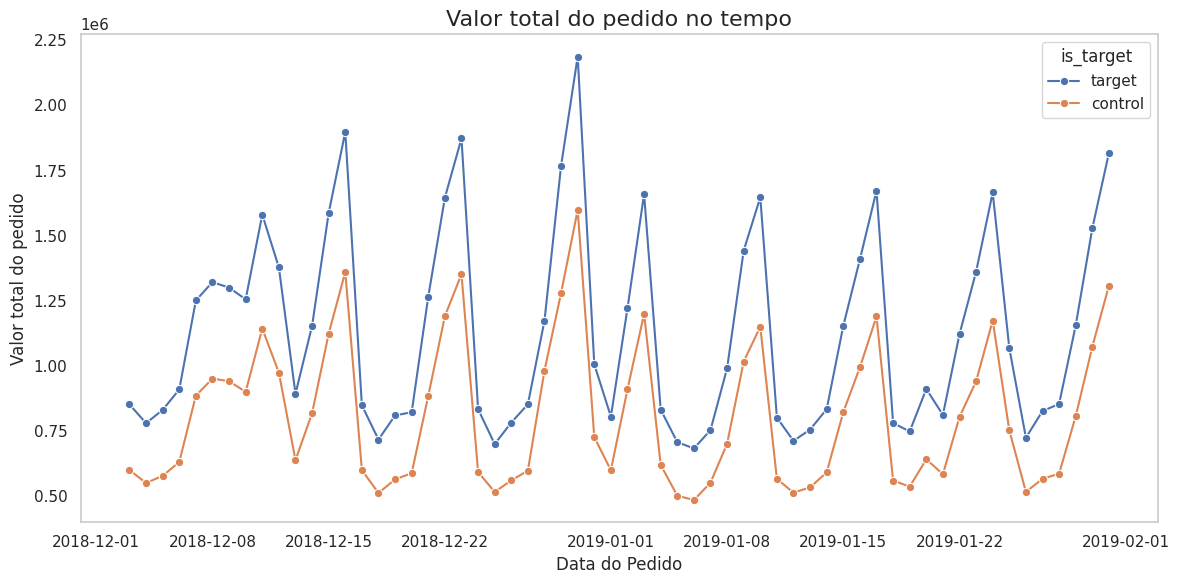

In [20]:
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")
sns.lineplot(data=df, x='order_created_day', y='order_total_amount', hue='is_target', marker='o', ci=None)

plt.title('Valor total do pedido no tempo', fontsize=16)
plt.xlabel('Data do Pedido', fontsize=12)
plt.ylabel('Valor total do pedido', fontsize=12)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(False)

plt.show()

<ipython-input-21-5e4c455fc92c>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='order_created_day', y='ticket_medio', hue='is_target', marker='o', ci=None)


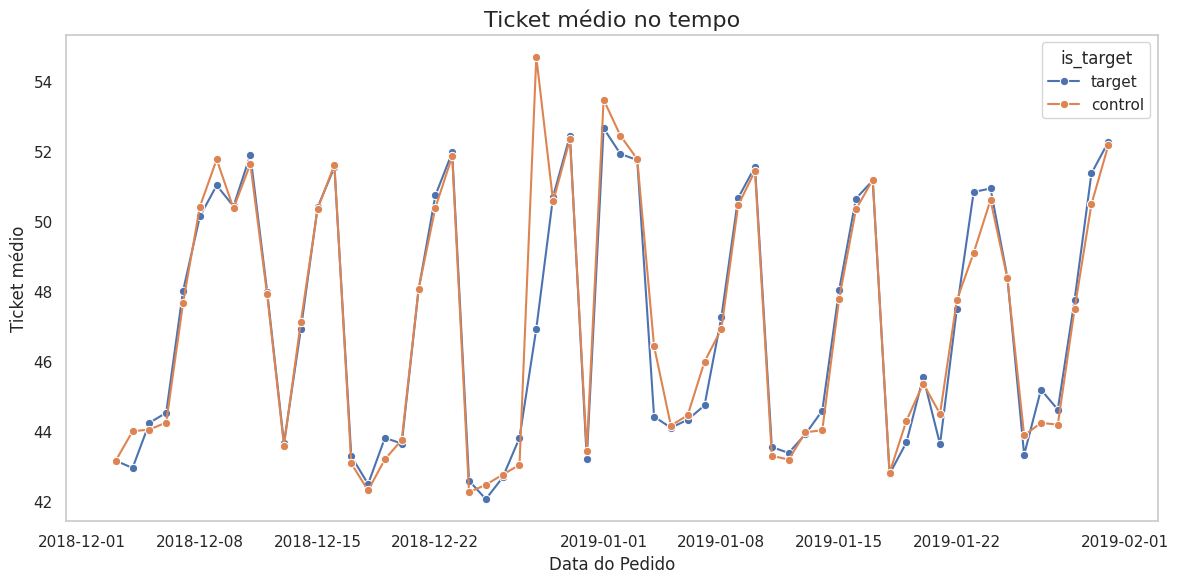

In [21]:
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")
sns.lineplot(data=df, x='order_created_day', y='ticket_medio', hue='is_target', marker='o', ci=None)

plt.title('Ticket médio no tempo', fontsize=16)
plt.xlabel('Data do Pedido', fontsize=12)
plt.ylabel('Ticket médio', fontsize=12)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(False)

plt.show()

<ipython-input-22-e4d52886e5e9>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=df, x='order_created_day', y='distinct_merchants', hue='is_target', marker='o', ci=None)


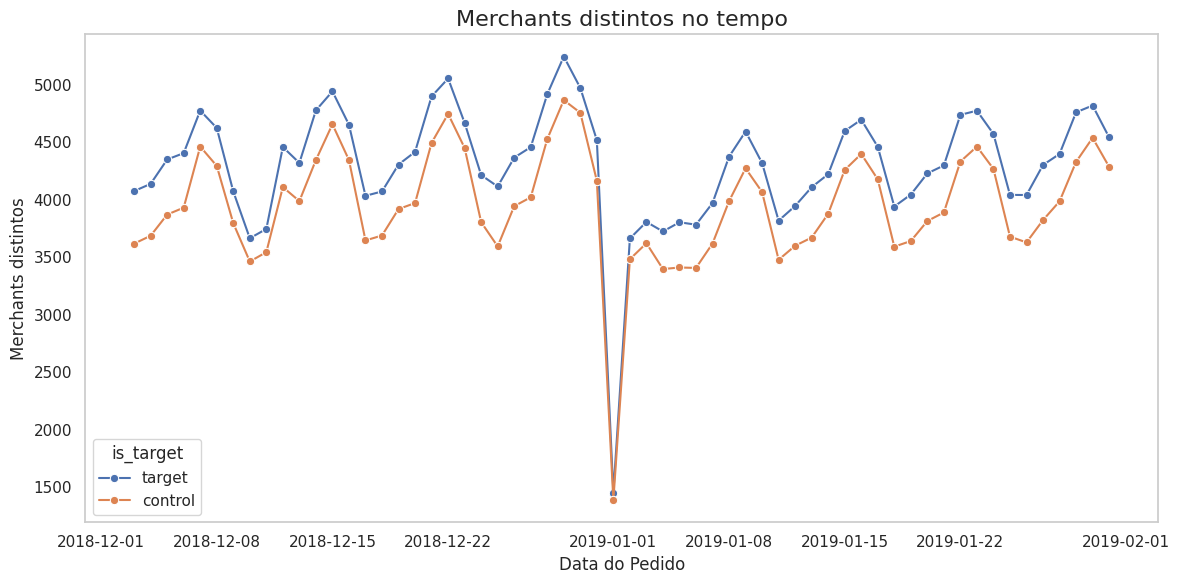

In [22]:
plt.figure(figsize=(12,6))
sns.set(style="whitegrid")
sns.lineplot(data=df, x='order_created_day', y='distinct_merchants', hue='is_target', marker='o', ci=None)

plt.title('Merchants distintos no tempo', fontsize=16)
plt.xlabel('Data do Pedido', fontsize=12)
plt.ylabel('Merchants distintos', fontsize=12)
# plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(False)

plt.show()

**Tempo entre compras**

In [23]:
df = pedidos_final.select("customer_id", "is_target", "order_created_day")

df_tempo_entre_compras = df.withColumn("order_previous_day", lag("order_created_day") \
                                       .over(Window.partitionBy("customer_id").orderBy("order_created_day"))) \
                            .withColumn("time_between_orders", date_diff("order_created_day", "order_previous_day"))

df_tempo_entre_compras.show()

+--------------------+---------+-----------------+------------------+-------------------+
|         customer_id|is_target|order_created_day|order_previous_day|time_between_orders|
+--------------------+---------+-----------------+------------------+-------------------+
|00006f567cb362ba9...|   target|       2019-01-01|              NULL|               NULL|
|00006f567cb362ba9...|   target|       2019-01-01|        2019-01-01|                  0|
|00006f567cb362ba9...|   target|       2019-01-02|        2019-01-01|                  1|
|00006f567cb362ba9...|   target|       2019-01-03|        2019-01-02|                  1|
|00006f567cb362ba9...|   target|       2019-01-24|        2019-01-03|                 21|
|0000bb10fb47a1d6b...|  control|       2018-12-21|              NULL|               NULL|
|0000bb10fb47a1d6b...|  control|       2018-12-21|        2018-12-21|                  0|
|0000c21984ae00cef...|  control|       2018-12-13|              NULL|               NULL|
|0000c2198

In [24]:
#entendendo o tempo médio entre compras dos usuários que possuem mais de uma compra
tempo_medio_entre_compras = df_tempo_entre_compras.where(col("time_between_orders").isNotNull()) \
.groupBy("is_target").agg(round(avg("time_between_orders"),2).alias("time_between_orders"))
tempo_medio_entre_compras.show()

+---------+-------------------+
|is_target|time_between_orders|
+---------+-------------------+
|  control|                7.9|
|   target|                7.9|
+---------+-------------------+



In [25]:
tempo_medio_entre_compras = df_tempo_entre_compras.groupBy("customer_id","is_target") \
.agg(round(avg("time_between_orders"),2).alias("avg_time_between_orders"),
     max("order_created_day").alias("time_last_order")) \
.withColumn("avg_time_between_orders", when(col("avg_time_between_orders").isNull(), 0).otherwise(col("avg_time_between_orders"))) \
.withColumn("recencia", date_diff(to_date(lit("2019-02-01")), "time_last_order")) \
.drop(col("time_last_order"))


tempo_medio_entre_compras.show()

+--------------------+---------+-----------------------+--------+
|         customer_id|is_target|avg_time_between_orders|recencia|
+--------------------+---------+-----------------------+--------+
|00006f567cb362ba9...|   target|                   5.75|       8|
|0000bb10fb47a1d6b...|  control|                    0.0|      42|
|0000c21984ae00cef...|  control|                   2.23|       1|
|0001226e517517758...|   target|                    7.0|      48|
|00016cfde8c0af0a4...|  control|                    0.0|      12|
|000200d3759a5b4d0...|   target|                    0.0|      57|
|00021cd56b6d6c980...|   target|                   11.5|      29|
|00021f6dc15d10418...|   target|                   37.0|      16|
|0002287b123ac1afc...|   target|                    0.0|      47|
|00022b8c0c7af061f...|  control|                   3.25|      19|
|00024bc2f09ce5769...|  control|                    0.0|      33|
|00027035d16a4de43...|  control|                    0.0|      31|
|000299d1a

In [26]:
frequencia_valor = pedidos_final.groupBy(col("customer_id"),col("is_target")) \
.agg(
      count_distinct(col("order_id")).alias("distinct_orders"),
      count_distinct(col("merchant_id")).alias("distinct_merchants"),
      round(sum(col("order_total_amount")),2).alias("order_total_amount"),
      round((sum(col("order_total_amount"))/count_distinct(col("order_id"))),2).alias("ticket_medio"))
frequencia_valor.show()

+--------------------+---------+---------------+------------------+------------------+------------+
|         customer_id|is_target|distinct_orders|distinct_merchants|order_total_amount|ticket_medio|
+--------------------+---------+---------------+------------------+------------------+------------+
|ddfdc1202bd21b07d...|  control|             18|                 7|            551.32|       30.63|
|ed858ee2b8b73a5c4...|  control|             32|                16|           1999.03|       62.47|
|bc03f83da6b98b509...|  control|              5|                 4|            245.11|       49.02|
|756a01d9c11d4affc...|  control|              1|                 1|              52.0|        52.0|
|04edd62e53c0b1700...|  control|              1|                 1|              48.0|        48.0|
|2ede26bdea707c792...|   target|              9|                 7|            508.55|       56.51|
|70388a43322330ac9...|  control|              2|                 2|             68.47|       34.24|


## **Perfil de compra dos usuários**

In [27]:
perfil_compra = tempo_medio_entre_compras.alias("t") \
.join(frequencia_valor.alias("f"), ["customer_id"], "inner") \
.withColumn("is_target_dummy", when(col("t.is_target") == "target", lit(1)).otherwise(lit(0))) \
.select("t.customer_id",
        "is_target_dummy",
        "avg_time_between_orders",
        "recencia",
        "distinct_orders",
        "distinct_merchants",
        "order_total_amount",
        "ticket_medio"
        )

perfil_compra.show()

+--------------------+---------------+-----------------------+--------+---------------+------------------+------------------+------------+
|         customer_id|is_target_dummy|avg_time_between_orders|recencia|distinct_orders|distinct_merchants|order_total_amount|ticket_medio|
+--------------------+---------------+-----------------------+--------+---------------+------------------+------------------+------------+
|00006f567cb362ba9...|              1|                   5.75|       8|              5|                 4|             533.1|      106.62|
|0000c21984ae00cef...|              0|                   2.23|       1|             23|                 8|           1011.36|       43.97|
|0001226e517517758...|              1|                    7.0|      48|              2|                 2|              86.5|       43.25|
|00021cd56b6d6c980...|              1|                   11.5|      29|              3|                 3|              47.8|       15.93|
|00021f6dc15d10418...|     

In [28]:
pd_perfil_compra = perfil_compra.toPandas()

pd_perfil_compra["is_target_dummy"] = pd_perfil_compra["is_target_dummy"].astype("int")

In [29]:
pd_perfil_compra.columns

Index(['customer_id', 'is_target_dummy', 'avg_time_between_orders', 'recencia',
       'distinct_orders', 'distinct_merchants', 'order_total_amount',
       'ticket_medio'],
      dtype='object')

**Correlação**

Text(0.5, 1.0, 'Correlação de Pearson')

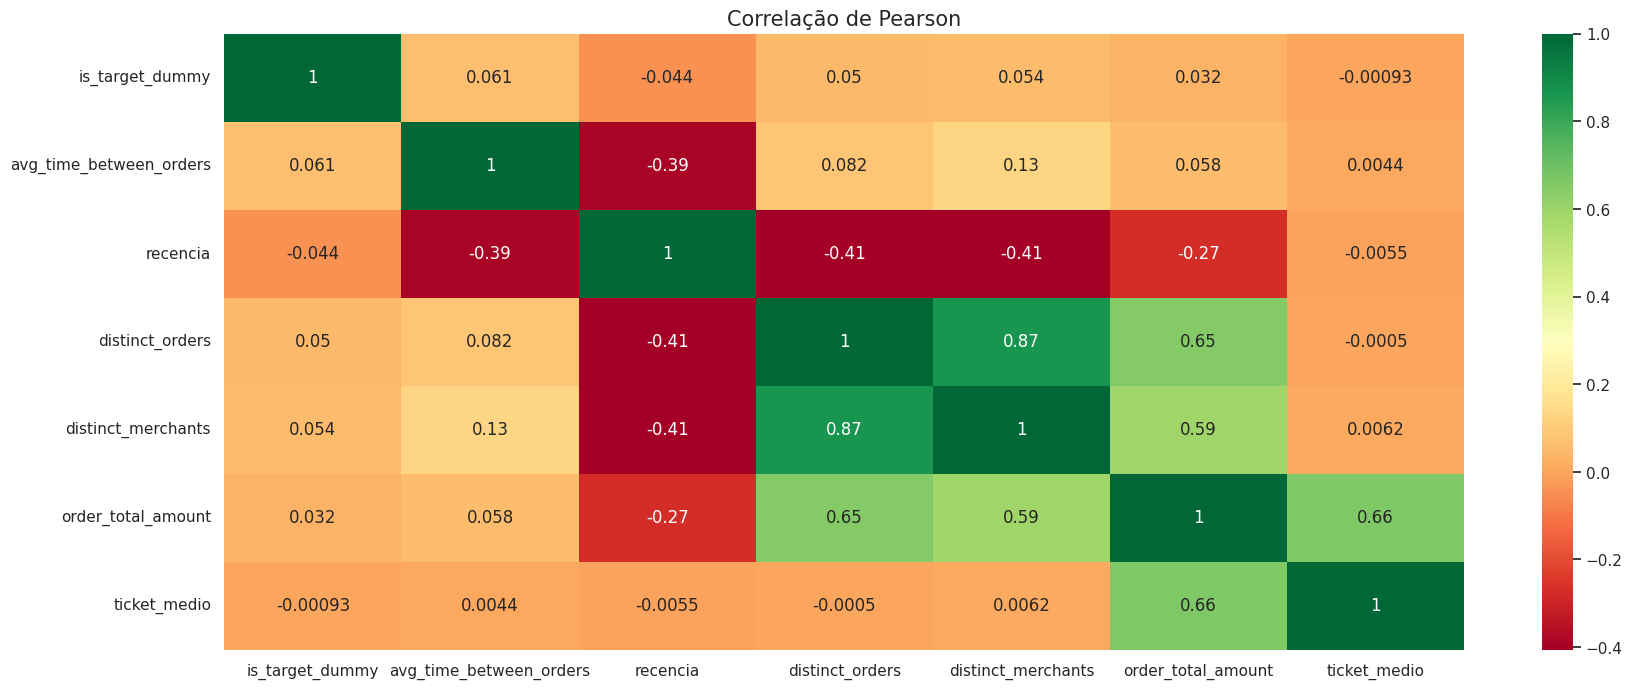

In [30]:
corr_perfil_compra = pd_perfil_compra.drop(columns=["customer_id"])

#correlação de pearson
plt.figure(figsize=(20,8))
sns.heatmap(corr_perfil_compra.corr(), annot = True, cmap = "RdYlGn");
plt.title('Correlação de Pearson', size = 15)

**Análise de correlação**

- Podemos perceber uma correlação forte entre distinct_merchants e distinct_order, o que nos leva a pensar que a medida que o números de pedidos aumentam, aumenta também a quantidade de restaurantes/estabelecimentos, sugerindo que usuários que mais compram, tendem a escolher locais diferentes para realizar suas compras. Lembrando que não indica causalidade.
Poder ser uma boa estretégia por exemplo realizar testes com usuários que possuem este comportamento, com intuito também de divulgar novos estabelecimentos, ajudando os merchants a encontrar o 'aha moment' na plataforma do Ifood e também já contribuindo para o engajamento deles.

- Também podemos perceber uma correlação negativa moderada entre recência e distinct_merchats, entendendo melhor os conceitos, temos que recência é o tempo desde a última compra (no caso da análise, foi considerado o tempo em dias), logo, uma baixa recência indica que uma compra foi feita recentemente. Usuários que compraram recentemente, tendem a comprar em um número maior de estabelecimentos, em um comportamento mais exploratório de lugares. Isto nos leva a algumas hipóteses como, usuários que não compram a muito tempo, podem ter alguns estabelecimentos de preferência, um comportamento que restrige a expansão de novos estabelecimentos. Uma segunda hipótese é de que usuários que compraram recentecemente podem estar ativos a pouco tempo na plataforma, ou até mesmo estar em uma localidade diferente, logo, buscam explorar mais opções.

## **Clusterização**

In [31]:
#fazendo o preprocessamento dos dados
# padronizar os dados pois os dados estão em escala diferentes, o método escolhido será MinMaxScaler, pois os dados não obedecem uma distribuição normal

#normalização das colunas numéricas
pd_perfil_compra_n = pd_perfil_compra.copy()

pd_perfil_compra_n = pd_perfil_compra_n.drop(columns=["customer_id", "is_target_dummy"])

minmax = MinMaxScaler()
#transformação de cada coluna e atribuição ao novo df codificado
for column in pd_perfil_compra_n:
  pd_perfil_compra_n[column] = minmax.fit_transform(pd_perfil_compra_n[[column]])

pd_perfil_compra_n

,avg_time_between_orders,recencia,distinct_orders,distinct_merchants,order_total_amount,ticket_medio
0,0.097458,0.118644,0.025641,0.088235,0.003799,0.001519
1,0.037797,0.000000,0.141026,0.205882,0.007207,0.000627
2,0.118644,0.796610,0.006410,0.029412,0.000616,0.000616
3,0.194915,0.474576,0.012821,0.058824,0.000341,0.000227
4,0.627119,0.254237,0.006410,0.029412,0.001244,0.001244
...,...,...,...,...,...,...
806461,0.135593,0.559322,0.012821,0.058824,0.000954,0.000636
806462,0.000000,0.372881,0.000000,0.000000,0.000353,0.000705
806463,0.067797,0.779661,0.006410,0.029412,0.000686,0.000686
806464,0.000000,0.813559,0.000000,0.000000,0.000170,0.000339


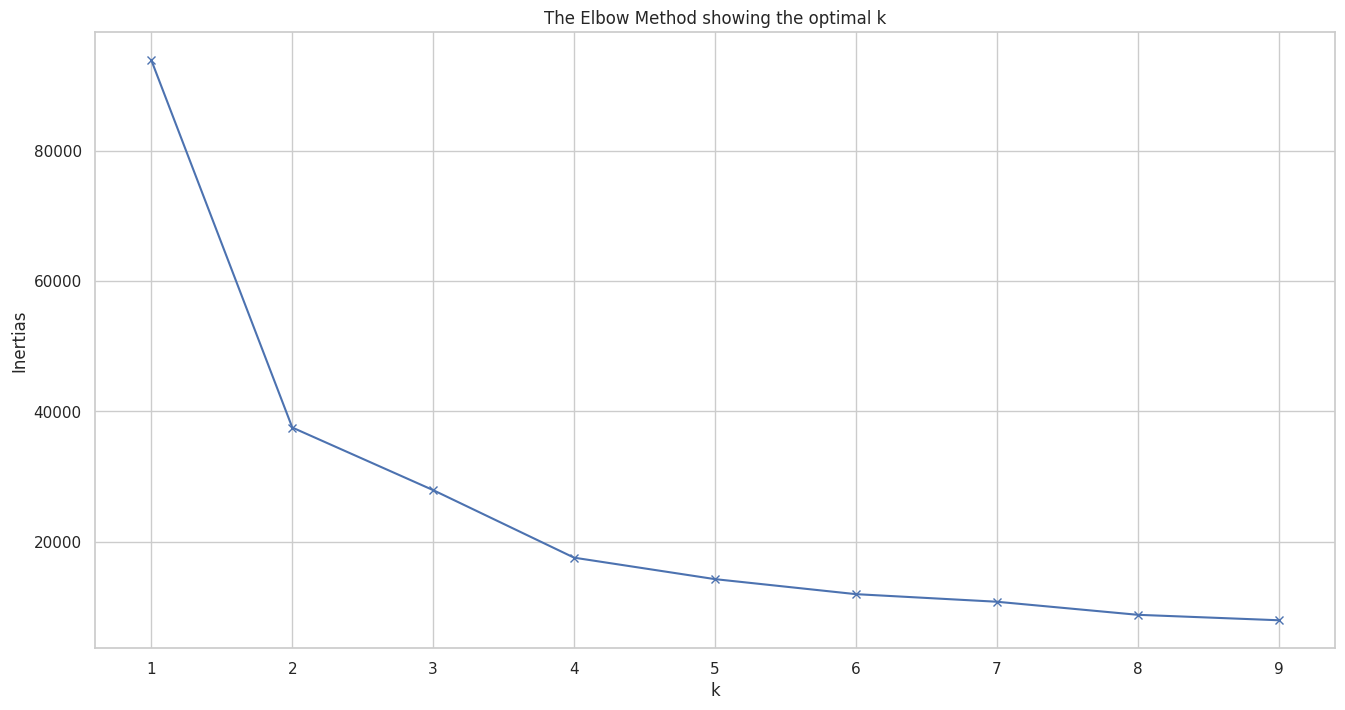

In [32]:
# elbow para ter insumos sobre a quantidade ideal de grupos
inertias = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, max_iter=300, random_state=13).fit(pd_perfil_compra_n)
    inertias.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertias')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**Número de clusters**


Aqui vamos assumir a quantidade ideal de clusters como 3. O estudo também poderia avaliar a performance com 4 clusteres através de métodos como Silhouette Score, porém para simplificar a análise, vamos seguir com 3 clusters.

In [33]:
model = KMeans(n_clusters=3).fit(pd_perfil_compra_n)
predict = model.predict(pd_perfil_compra_n)
pd_perfil_compra["Clusters"] = predict
pd_perfil_compra["Clusters"].value_counts()


,count
Clusters,
2,375946
1,339364
0,91156


In [34]:
pd_perfil_compra.groupby("Clusters")[["avg_time_between_orders", "recencia", "distinct_orders", "distinct_merchants", "order_total_amount", "ticket_medio"]].mean()



,avg_time_between_orders,recencia,distinct_orders,distinct_merchants,order_total_amount,ticket_medio
Clusters,,,,,,
0,28.487982,10.038154,2.460672,1.981208,119.879334,48.798553
1,1.919762,40.619948,1.543832,1.358406,72.674982,47.555597
2,5.112145,10.101600,4.466570,2.852242,214.315877,48.014970


## Análise dos clusters

- Cluster 0: Menor tempo entre pedidos (2 dias) porém menor quantidade de pedidos por usuários, o total médio gasto por estes usuários também é menor e sugerem um comportamento mais conservador pois geralmente compram no mesmo estabeleciomento;
- Cluster 1: Maior tempo entre pedidos: usuários compram a cada 10 dias, porém estes usuários compraram mais recentemente entre os demais. Também possuem maior quantidade de pedidos por usuário e buscam comprar em estabelecimentos diferentes, em média 3 pedidos por usuário. Apesar do ticket médio deste grupo de usuário ser maior entre os clusters, a diferença não é impactante.
- Cluster 2: Tempo entre compras em média a cada 3 dias, e possuem em média 2 pedidos por usuário. Possue menor ticket médio, porém a diferença não é impactante entre os demais clusters.

Recomendações:
Para uma nova campanha, caso o objetivo seja aumentar o engajamento de usuários, ou aumentar a quantidade de usuários ativos, o Cluster 0 é um ótimo grupo de usuários a serem imapctados devido ao seu comportamento mais 'tímido' de compra.

Caso o objeito seja aumentar a quantidade de pedidos gerados ou aumento de receita, o grupo 1 é o mais indicado pois são usuários que exploram mais estabelecimentos, e tem uma volumetria de pedidos maior por usuário.




---


# Teste de Hipótese:

In [35]:
#qtd de pedidos por usuário
df_media_pedidos = pedidos_final.groupBy(col("customer_id"), col("is_target")).agg(count_distinct("order_id").alias("qtd_pedidos_por_usuario"))

df_media_pedidos.groupBy(col("is_target")).agg(avg(col("qtd_pedidos_por_usuario")).alias("media_pedidos_por_usuario")).show()

+---------+-------------------------+
|is_target|media_pedidos_por_usuario|
+---------+-------------------------+
|  control|         2.80338490383922|
|   target|        3.176947192795185|
+---------+-------------------------+



# Usuários target compram mais do que usuários control?
Primeiramente vamos validar se os dados possuem uma distribuição normal

##Teste de Shapiro Wilk

**- H0:** A amostra segue uma distribuição normal

**- H1:** A amostra não segue uma distribuição normal
- Se _p-value_ < 0.05, rejeita-se a hipótese nula, ou seja, temos evidências suficientes para dizer que a amostra não vem de distribuição normal


In [36]:
pd_pedidos = df_media_pedidos.toPandas()

In [37]:
# analisando se os dados obedecem uma distribuição normal
statistic, pvalue = shapiro(pd_pedidos["qtd_pedidos_por_usuario"])
print(f"statistic={statistic}, pvalue={pvalue}")
if pvalue < 0.05:
    print('Rejeita a hipótese nula')
else:
    print('Não rejeita a hipótese nula')

statistic=0.5633321475085724, pvalue=8.558000673904252e-203
Rejeita a hipótese nula


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 806466.
  res = hypotest_fun_out(*samples, **kwds)


Como os dados não seguem uma distribuição normal, logo, seguiremos por testes não paramétricos

## Hipóteses
**H0:** quantidade de pedidos do grupo target é igual ao grupo control

**H1:** quantidade de pedidos do grupo target é diferente ao grupo control

In [38]:
target = pd_pedidos[pd_pedidos["is_target"]=="target"]
control = pd_pedidos[pd_pedidos["is_target"]=="control"]

statistic, pvalue = mannwhitneyu(target["qtd_pedidos_por_usuario"], control["qtd_pedidos_por_usuario"])
print(f"statistic={statistic}, pvalue={pvalue}")

if pvalue < 0.05:
    print('Rejeita a hipótese nula')
else:
    print('Não rejeita a hipótese nula')


statistic=88361946996.0, pvalue=0.0
Rejeita a hipótese nula
0.5496023311179173


## Resultado:
Rejeitamos a hipótese nula (H₀) e aceitamos a hipótese alternativa, ou seja, há uma diferença significativa entre a quantidade de pedidos dos dois grupos


---


## Vamos analisar agora se a diferença é para mais ou para menos
**H0:** usuários do grupo target tem igual ou menor quatidade de pedidos que o contro control

**H1:** usuários do grupo target tem maior quatidade de pedidos que o contro control

In [39]:

target = pd_pedidos[pd_pedidos["is_target"]=="target"]
control = pd_pedidos[pd_pedidos["is_target"]=="control"]

statistic, pvalue = mannwhitneyu(target["qtd_pedidos_por_usuario"], control["qtd_pedidos_por_usuario"], alternative='greater')
print(f"statistic={statistic}, pvalue={pvalue}")

if pvalue < 0.05:
    print('Rejeita a hipótese nula')
else:
    print('Não rejeita a hipótese nula')


statistic=88361946996.0, pvalue=0.0
Rejeita a hipótese nula


## Resultado do teste de hipótese:
Novamente rejeitamos a hipótese nula (H₀) concluindo que o grupo target realizou mais pedidos em relação ao grupo control.
É importante orientar que apesar de ter relevância estatística, não quer dizer que na prática a diferença tenha um impacto real.



---




# Usuários target tem ticket médio maior do que usuários control?


## Hipóteses
**H0:** ticket médio do grupo target é igual ao grupo control

**H1:** ticket médio do grupo target é diferente ao grupo control


In [40]:
#ticket_medio
df_ticket_medio = pedidos_final.groupBy(col("customer_id"), col("is_target")).agg(round((sum(col("order_total_amount"))/count_distinct(col("order_id"))),2).alias("ticket_medio"))


df_ticket_medio.groupBy(col("is_target")).agg(avg(col("ticket_medio")).alias("ticket_medio")).show()

+---------+------------------+
|is_target|      ticket_medio|
+---------+------------------+
|  control| 48.00312479545926|
|   target|47.835127891767534|
+---------+------------------+



In [41]:
pd_ticket_medio = df_ticket_medio.toPandas()

In [42]:
target = pd_ticket_medio[pd_ticket_medio["is_target"]=="target"]
control = pd_ticket_medio[pd_ticket_medio["is_target"]=="control"]

statistic, pvalue = mannwhitneyu(target["ticket_medio"], control["ticket_medio"])
print(f"statistic={statistic}, pvalue={pvalue}")

if pvalue < 0.05:
    print('Rejeita a hipótese nula')
else:
    print('Não rejeita a hipótese nula')


statistic=80869512989.5, pvalue=3.4783921195276324e-06
Rejeita a hipótese nula
0.5030001529664336


In [43]:
target = pd_ticket_medio[pd_ticket_medio["is_target"]=="target"]
control = pd_ticket_medio[pd_ticket_medio["is_target"]=="control"]

statistic, pvalue = mannwhitneyu(target["ticket_medio"], control["ticket_medio"])
print(f"statistic={statistic}, pvalue={pvalue}")

if pvalue < 0.05:
    print('Rejeita a hipótese nula')
else:
    print('Não rejeita a hipótese nula')

statistic=80869512989.5, pvalue=3.4783921195276324e-06
Rejeita a hipótese nula



É importante orientar que apesar de ter relevância estatística, não quer dizer que na prática a diferença tenha um impacto real, visto que a diferença é de R$0,17, ou seja, vale entender o valor do investimento feito para a campanha, o valor do cupom enviado para os usuários para uma análise mais profunda sobre ROI.

---
# Sugestão de Teste A/B
- Todos os usuários do teste a/b tem algum pedido, logo, uma sugestão é ter uma base sobre todos os usuários que receberam cupons para conseguirmos calcular conversão;
- Teste com diferentes valores de cupons para entender se o valor do desconto impacta no ticket médio;
- Frete grátis: entender se cupons de frete grátis aumentam o ticket médio;
- Avaliar base de de satisfação (NPS) para entender se a disponibilização de cupons impactam na experiencia e satisfação do usuário;
- Carrinho abandonado: teste a/b de envio de cupons para usuários que abandonaram carrinho e analisar a finalização da compra (conversão). Aplicável principalmente para usuários de produtos de farmácia e mercado, visto que a compra de refeições é feita de um modo mais rápido, isto é, o usuários tendem a não passar horas ou até dias realizando pesquisa ou aguardando antes da finalização da compra.
---

# Conclusão

Apesar do grupo target gerar mais pedidos e terem um valor de compra superior ao grupo control, ao analisar comportamento do usuário, essa diferença não é impactante. Dessa forma, analisando em grupo, nota-se o impacto na volumetria de pedidos, porém, os cupons não impactaram no comportamento individual de compra dos usuários.